<a href="https://colab.research.google.com/github/jonkrohn/ML-foundations/blob/master/notebooks/gradient-descent-from-scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient Descent from Scratch

This notebook is similar to the [*Batch Regression Gradient* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/batch-regression-gradient.ipynb) with the critical exception that we optimize via gradient descent without relying on the built-in PyTorch `SGD()` optimizer. 

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [2]:
xs = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7.])
ys = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37])

In [3]:
def regression(my_x, my_m, my_b):
    return (my_m * my_x) + my_b

In [4]:
m = torch.tensor([0.9]).requires_grad_()
b = torch.tensor([0.1]).requires_grad_()

**Step 1**: Forward pass

In [5]:
yhats = regression(xs, m, b)
yhats

tensor([0.1000, 1.0000, 1.9000, 2.8000, 3.7000, 4.6000, 5.5000, 6.4000],
       grad_fn=<AddBackward0>)

**Step 2**: Compare $\hat{y}$ with true $y$ to calculate cost $C$

Mean squared error: $$C = \frac{1}{n} \sum_{i=1}^n (\hat{y_i}-y_i)^2 $$

In [6]:
def mse(my_yhat, my_y): 
    sigma = torch.sum((my_yhat - my_y)**2)

    return sigma / len(my_y)

In [7]:
C = mse(yhats, ys)
C

tensor(19.6755, grad_fn=<DivBackward0>)

**Step 3**: Use autodiff to calculate gradient of $C$ w.r.t. parameters

In [8]:
C.backward()

In [9]:
m.grad

tensor([36.3050])

$\frac{\partial C}{\partial m} = 36.3$ indicates that an increase in $m$ corresponds to a large increase in $C$. 

In [10]:
b.grad

tensor([6.2650])

Meanwhile, $\frac{\partial C}{\partial b} = 6.26$ indicates that an increase in $b$ also corresponds to an increase in $C$, though much less so than $m$.

(Using partial derivatives derived in [*Calculus II*](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/4-calculus-ii.ipynb), we could alternatively calculate these same slopes without automatic numerical computation:)

$$ \frac{\partial C}{\partial m} = \frac{2}{n} \sum (\hat{y}_i - y_i) \cdot x_i $$

In [11]:
(2 / len(ys)) * torch.sum((yhats - ys)*xs)

tensor(36.3050, grad_fn=<MulBackward0>)

$$ \frac{\partial C}{\partial b} = \frac{2}{n} \sum (\hat{y}_i - y_i) $$

In [12]:
(2 / len(ys)) * torch.sum((yhats - ys))

tensor(6.2650, grad_fn=<MulBackward0>)

The gradient of cost, $\nabla C$, is: 

In [13]:
gradient = torch.tensor([[b.grad.item(), m.grad.item()]]).T
gradient

tensor([[ 6.2650],
        [36.3050]])

For convenience, model parameters are often denoted as $\boldsymbol{\theta}$, which, depending on the model, could be, for example, a vector, a matrix, or a collection of tensors of varying dimensions. With our simple linear model, a vector tensor will do:

In [14]:
theta = torch.tensor([[b, m]]).T 
theta

tensor([[0.1000],
        [0.9000]])

Note the gradient $\nabla C$ could thus alternatively be denoted with respect to  $\boldsymbol{\theta}$ as $\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta})$.

(Also, note that we're transposing $\boldsymbol{\theta}$ to make forthcoming tensor operations easier because of the convention in ML to transpose the gradient, $\nabla C$.)

Let's visualize the state of the most pertinent metrics in a single plot: 

In [15]:
def labeled_regression_plot(my_x, my_y, my_m, my_b, my_C, include_grad=True):
    title = 'Cost = {}'.format('%.3g' % my_C.item())
    if include_grad:
        xlabel = 'm = {}, m grad = {}'.format('%.3g' % my_m.item(), '%.3g' % my_m.grad.item())
        ylabel = 'b = {}, b grad = {}'.format('%.3g' % my_b.item(), '%.3g' % my_b.grad.item())
    else:
        xlabel = 'm = {}'.format('%.3g' % my_m.item())        
        ylabel = 'b = {}'.format('%.3g' % my_b.item())
    
    fig, ax = plt.subplots()
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

    ax.scatter(my_x, my_y)
    
    x_min, x_max = ax.get_xlim()
    y_min = regression(x_min, my_m, my_b).detach().numpy()
    y_max = regression(x_max, my_m, my_b).detach().numpy()

    ax.set_xlim([x_min, x_max])
    _ = ax.plot([x_min, x_max], [y_min, y_max], c='C01')

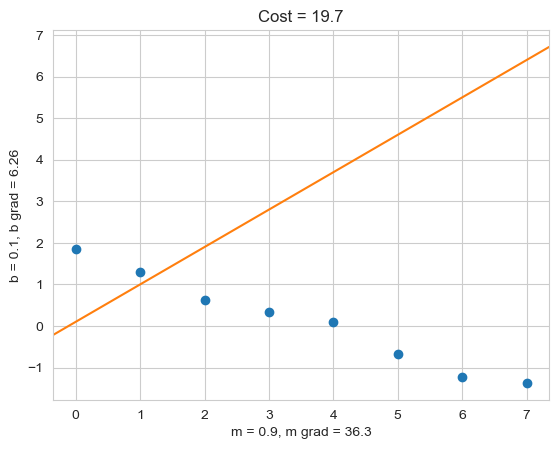

In [16]:
labeled_regression_plot(xs, ys, m, b, C)

**Step 4**: Gradient descent

In the first round of training, with $\frac{\partial C}{\partial m} = 36.3$ and $\frac{\partial C}{\partial b} = 6.26$, the lowest hanging fruit with respect to reducing cost $C$ is to decrease the slope of the regression line, $m$. The model would also benefit from a comparatively small decrease in the $y$-intercept of the line, $b$. 

To control exactly how much we adjust the model parameters $\boldsymbol{\theta}$, we set a **learning rate**, a hyperparameter of ML models that use gradient descent (that is typically denoted with $\alpha$): 

In [17]:
lr = 0.01 # Cover rules of thumb

We use the learning rate $\alpha$ to scale the gradient, i.e., $\alpha \nabla C$:

In [18]:
scaled_gradient = lr * gradient
scaled_gradient

tensor([[0.0626],
        [0.3630]])

We can now use our scaled gradient to adjust our model parameters $\boldsymbol{\theta}$ in directions that will reduce the model cost $C$. 

Since, e.g., $\frac{\partial C}{\partial m} = 36.3$ indicates that increasing the slope parameter $m$ corresponds to an increase in cost $C$, we *subtract* the gradient to adjust each individual parameter in a direction that reduces cost: $$ \boldsymbol{\theta}' = \boldsymbol{\theta} - \alpha \nabla C$$

In [19]:
new_theta = theta - scaled_gradient
new_theta

tensor([[0.0374],
        [0.5369]])

To see these adjustments even more clearly, you can consider each parameter individually, e.g., $m' = m - \alpha \frac{\partial C}{\partial m}$:

In [20]:
m - (lr * m.grad)

tensor([0.5369], grad_fn=<SubBackward0>)

...and $b' = b - \alpha \frac{\partial C}{\partial b}$: 

In [21]:
b - (lr * b.grad)

tensor([0.0374], grad_fn=<SubBackward0>)

With our updated parameters $\boldsymbol{\theta}$ now in hand, we can use them to check that they do indeed correspond to a decreased cost $C$:

In [22]:
b = new_theta[0]
m = new_theta[1]

In [23]:
C = mse(regression(xs, m, b), ys)

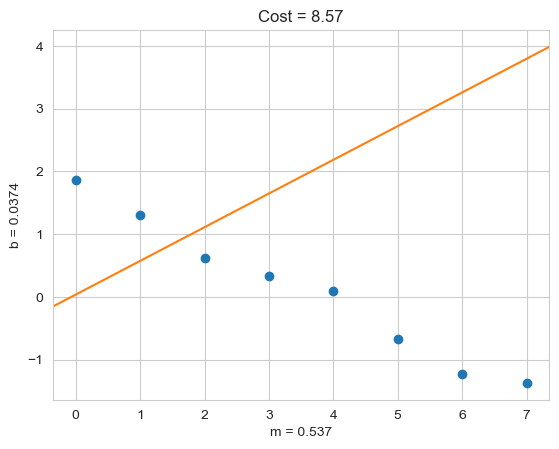

In [24]:
labeled_regression_plot(xs, ys, m, b, C, include_grad=False) # Gradient of C hasn't been recalculated

### Rinse and Repeat

To perform another round of gradient descent, we let PyTorch know we'd like to track gradients on the tensors `b` and `m` (as we did at the top of the notebook when we created them the first time): 

In [25]:
b.requires_grad_()
_ = m.requires_grad_() # "_ =" is to prevent output within Jupyter; it is cosmetic only

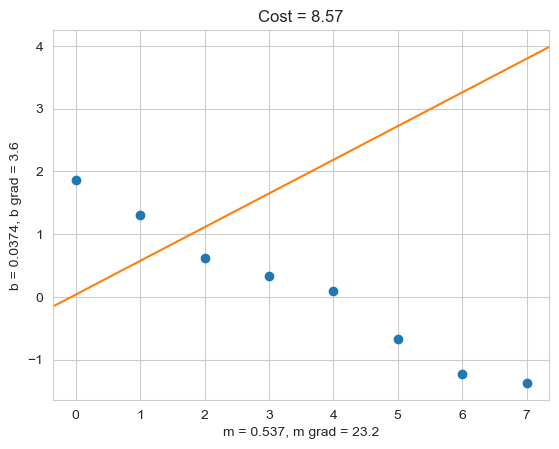

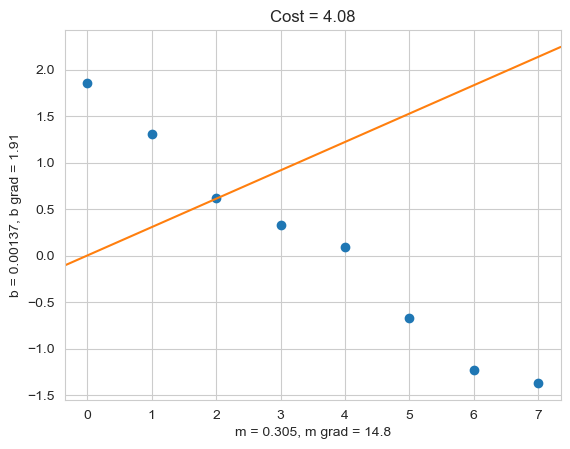

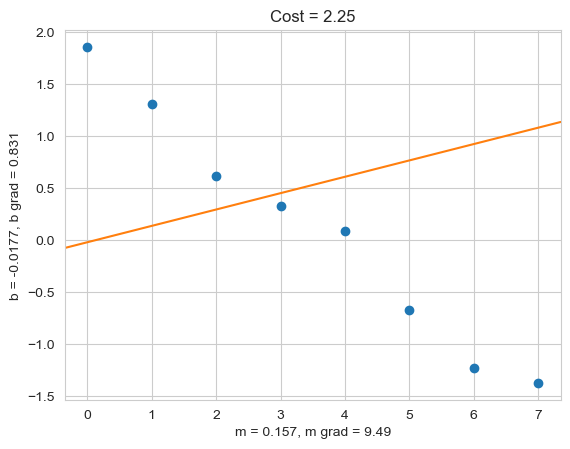

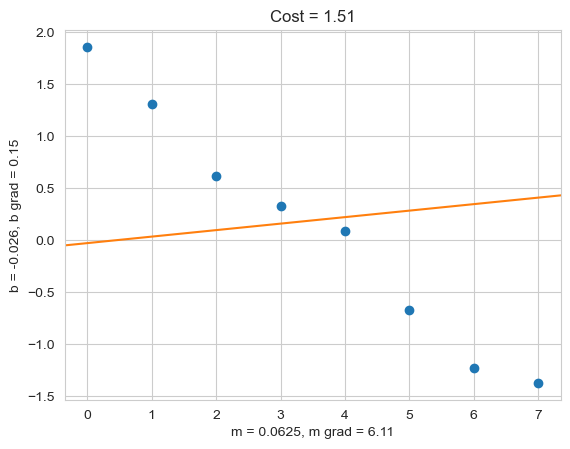

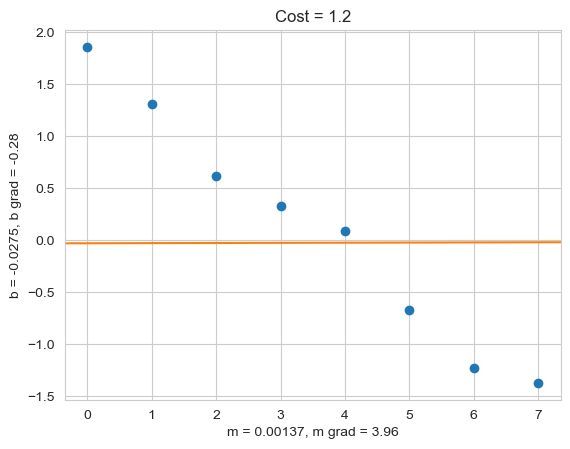

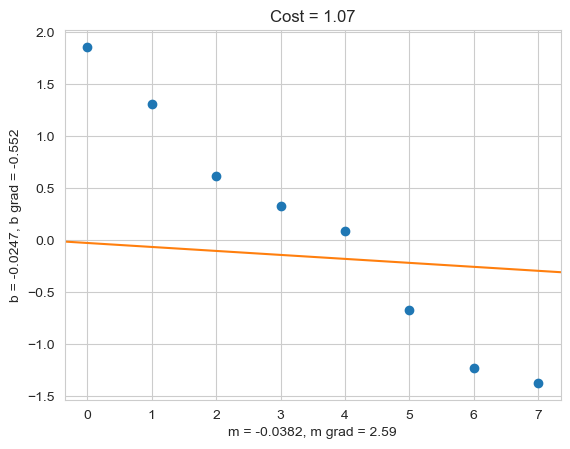

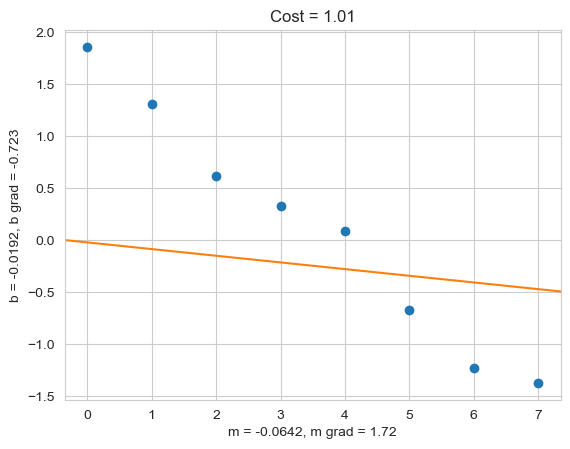

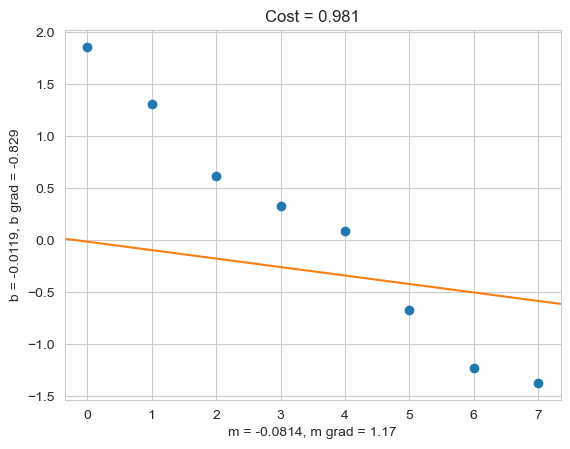

In [26]:
epochs = 8
for epoch in range(epochs): 
    yhats = regression(xs, m, b) # Step 1
    C = mse(yhats, ys) # Step 2
    C.backward() # Step 3
    labeled_regression_plot(xs, ys, m, b, C)
    gradient = torch.tensor([[b.grad.item(), m.grad.item()]]).T
    theta = torch.tensor([[b, m]]).T 
    new_theta = theta - (lr * gradient) # Step 4
    b = new_theta[0].requires_grad_()
    m = new_theta[1].requires_grad_()

(Note that the above plots are identical to those in the [*Batch Regression Gradient* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/batch-regression-gradient.ipynb), in which we used the PyTorch `SGD()` method to descend the gradient.)

In later rounds of training, after the model's slope $m$ has become closer to the slope represented by the data, $\frac{\partial C}{\partial b}$ becomes negative, indicating an inverse relationship between $b$ and $C$. Meanwhile, $\frac{\partial C}{\partial m}$ remains positive. 

This combination directs gradient descent to simultaneously adjust the $y$-intercept $b$ upwards and the slope $m$ downwards in order to reduce cost $C$ and, ultimately, fit the regression line snugly to the data. 

Finally, let's run a thousand more epochs (without plots) to converge on optimal parameters $\boldsymbol{\theta}$: 

In [27]:
epochs = 992 # accounts for rounds above to match 1000 epochs of regression-in-pytorch.ipynb
for epoch in range(epochs):
    yhats = regression(xs, m, b) # Step 1
    C = mse(yhats, ys) # Step 2
    C.backward() # Step 3
    if epoch %10 == 0:
        print('Epoch {}, cost {}, m grad {}, b grad {}'.format(epoch, '%.3g' % C.item(), '%.3g' % m.grad.item(), '%.3g' % b.grad.item()))
    gradient = torch.tensor([[b.grad.item(), m.grad.item()]]).T
    theta = torch.tensor([[b, m]]).T 
    new_theta = theta - (lr * gradient) # Step 4
    b = new_theta[0].requires_grad_()
    m = new_theta[1].requires_grad_()

Epoch 0, cost 0.962, m grad 0.82, b grad -0.894
Epoch 10, cost 0.854, m grad 0.202, b grad -0.96
Epoch 20, cost 0.763, m grad 0.185, b grad -0.908
Epoch 30, cost 0.682, m grad 0.174, b grad -0.857
Epoch 40, cost 0.61, m grad 0.164, b grad -0.808
Epoch 50, cost 0.545, m grad 0.155, b grad -0.763
Epoch 60, cost 0.488, m grad 0.146, b grad -0.72
Epoch 70, cost 0.437, m grad 0.138, b grad -0.68
Epoch 80, cost 0.391, m grad 0.13, b grad -0.642
Epoch 90, cost 0.351, m grad 0.123, b grad -0.605
Epoch 100, cost 0.314, m grad 0.116, b grad -0.571
Epoch 110, cost 0.282, m grad 0.11, b grad -0.539
Epoch 120, cost 0.253, m grad 0.104, b grad -0.509
Epoch 130, cost 0.228, m grad 0.0977, b grad -0.48
Epoch 140, cost 0.205, m grad 0.0922, b grad -0.453
Epoch 150, cost 0.185, m grad 0.087, b grad -0.428
Epoch 160, cost 0.167, m grad 0.0821, b grad -0.404
Epoch 170, cost 0.151, m grad 0.0775, b grad -0.381
Epoch 180, cost 0.136, m grad 0.0732, b grad -0.36
Epoch 190, cost 0.124, m grad 0.0691, b grad -

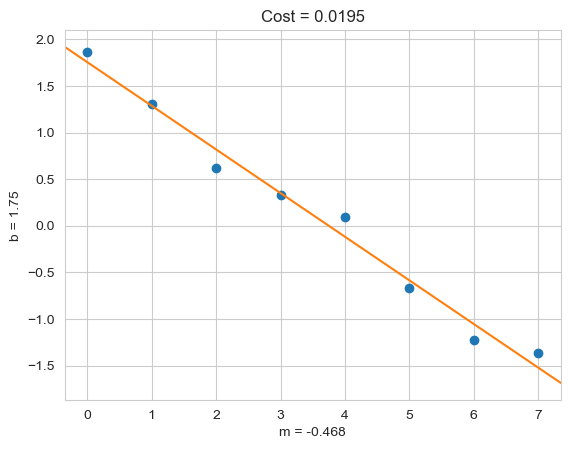

In [28]:
labeled_regression_plot(xs, ys, m, b, C, include_grad=False)

(Note that the above results are identical to those in the [*Regression in PyTorch* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/regression-in-pytorch.ipynb), in which we also used the PyTorch `SGD()` method to descend the gradient.)